## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install colorama
!pip install yfinance statsmodels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from colorama import Fore, Style
from keras.optimizers import Adam
from sklearn.metrics import r2_score
import tensorflow as tf
from google.colab import drive
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

## Data Understanding

Mengambil Data dari Google drive: Menggunakan library gdown untuk mendownload data harga saham BBCA selama 5 tahun terakhir.

In [3]:
import gdown

# Download file dari Google Drive
file_id = "1reiW85TioMzROXzXqjyLcRTOzS43scI5"
url = f"https://drive.google.com/uc?id={file_id}"
output = "bbca_5y.csv"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1reiW85TioMzROXzXqjyLcRTOzS43scI5
To: /content/bbca_5y.csv
100%|██████████| 90.5k/90.5k [00:00<00:00, 59.8MB/s]


'bbca_5y.csv'

In [4]:
# Load CSV ke DataFrame
data = pd.read_csv(output, index_col="Date", parse_dates=True)

data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,5200.0,5200.0,5200.0,5200.0,4629.854004,0
2019-01-02,5200.0,5245.0,5200.0,5240.0,4665.468262,35956000
2019-01-03,5200.0,5220.0,5115.0,5180.0,4612.046387,72358000
2019-01-04,5175.0,5205.0,5125.0,5205.0,4634.305176,51465000
2019-01-07,5265.0,5325.0,5245.0,5245.0,4669.920898,73438000


Visualisasi Data: Memplot grafik harga penutupan saham BBCA untuk menggambarkan pergerakan harga selama periode yang ditentukan.

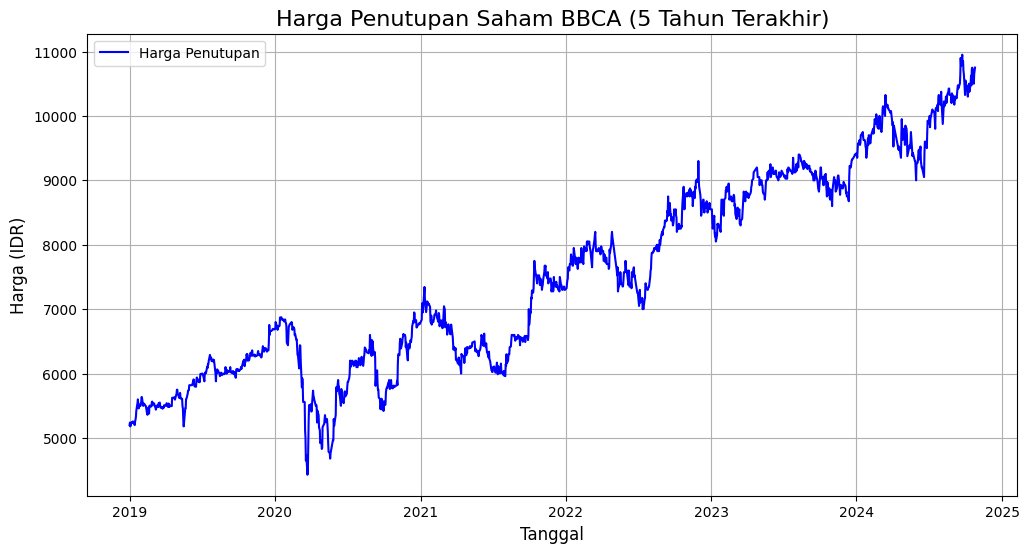

In [5]:
# Plot harga penutupan (Close)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Harga Penutupan', color='blue')

# Menambahkan judul dan label
plt.title('Harga Penutupan Saham BBCA (5 Tahun Terakhir)', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR)', fontsize=12)

# Menampilkan grid dan legenda
plt.grid(True)
plt.legend()

# Tampilkan grafik
plt.show()

Mengecek missing value pada data

In [6]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


Mendeteksi outlier menggunakan metode IQR (interquartile Range)

In [9]:
Q1 = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].quantile(0.25)
Q3 = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].quantile(0.75)
IQR = Q3 - Q1

outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
outlier_count = outliers.sum()
outlier_count

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,73


Mengecek duplikat data

In [8]:
data.duplicated().sum()

6

Mengecek detail data dengan fungsi info()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1426 entries, 2019-01-01 to 2024-10-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1426 non-null   float64
 1   High       1426 non-null   float64
 2   Low        1426 non-null   float64
 3   Close      1426 non-null   float64
 4   Adj Close  1426 non-null   float64
 5   Volume     1426 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 78.0 KB


Selanjutnya kita melakukan decomposisi komponen waktu menggunakan metode seasonal decomposition. Dengan metode ini, data dapat dipecah menjadi tiga komponen utama: Trend, Seasonal, dan Residual, Untuk memahami lebih dalam struktur data harga saham BCA.

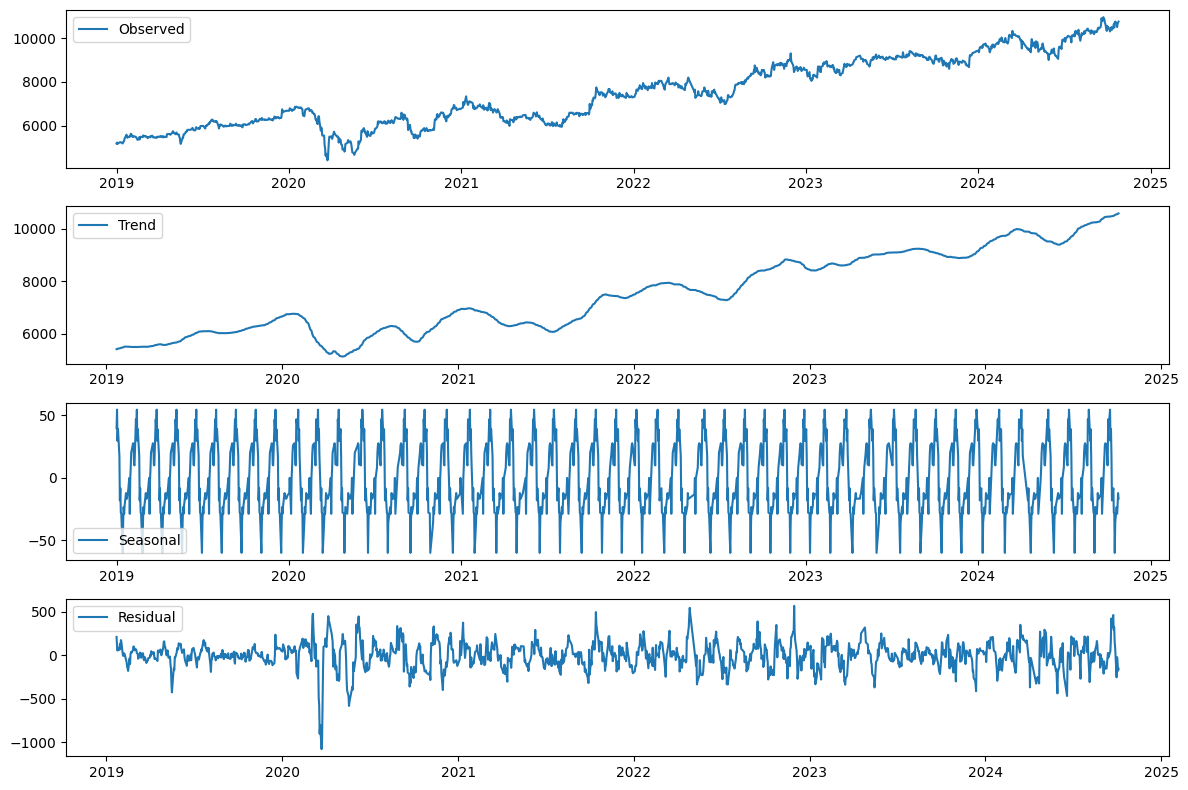

In [7]:
result = seasonal_decompose(data['Close'], model='additive', period=30)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Data Preparation

Mengambil fitur Close atau harga penutupan sebagai fitur target yang akan digunakan untuk memprediksi harga saham BBCA

In [8]:
data = data[['Close']]
data.head()

,Close
Date,
2019-01-01,5200.0
2019-01-02,5240.0
2019-01-03,5180.0
2019-01-04,5205.0
2019-01-07,5245.0


Menetapkan frekuensi harian dan menginterpolasi nilai NaN

In [9]:
data = data.asfreq(freq='D')
data.interpolate(inplace=True)

data.head()

,Close
Date,
2019-01-01,5200.000000
2019-01-02,5240.000000
2019-01-03,5180.000000
2019-01-04,5205.000000
2019-01-05,5218.333333


In [10]:
# Membagi data menjadi train dan test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

print(f"Train Size: {train_size}")
print(f"Test Size: {test_size}")

Train Size: 1700
Test Size: 425


Lengkah selanjutnya yaitu melakukan normalisasi data harga penutupan menggunakan MinMaxScaler ke rentang -1 hingga 0, mengatur time step menjadi 60 hari, membagi data menjadi set pelatihan dan pengujian, serta membentuk dataset dengan window 60 hari untuk digunakan dalam pelatihan model.

In [11]:
# Normalisasi data
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
data_scaled = scaler.fit_transform(dataset)

# Membuat dataset dengan window 60 hari
time_step = 60

# Membagi data menjadi train dan test
train_data, test_data = data_scaled[:train_size-time_step,:], data_scaled[train_size-time_step:,:]

# Fungsi untuk membuat dataset dengan window (time_step)
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Mengambil window data
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Nilai target
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input ke [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(len(x_train), len(x_test))

1579 424


## Modeling

Selanjutnya adalah tahap modeling, disini kita akan menggunakan algoritma LSTM dan ARIMA. Kemudian kita akan membandingkan mana yang terbaik untuk memprediksi harga saham bbca

## 1. LSTM

Untuk model LSTM, disini saya menggunakan arsitektur 2 layer LSTM dengan masing-masing 50 unit, dan satu layer output. Konfigurasi ini diharapkan mampu menangkap pola yang ada dalam data time series.

Parameter yang digunakan adalah sebagai berikut:

- Loss Function: Mean Squared Error (MSE), yang umum digunakan dalam pemodelan regresi untuk menghitung selisih kuadrat antara nilai prediksi dan nilai aktual.
- Metrik Evaluasi: Mean Absolute Error (MAE), yang lebih mudah diinterpretasikan karena menampilkan kesalahan dalam satuan aslinya.
- Optimizer yang digunakan adalah Adam, yang cukup stabil dan efektif dalam mengidentifikasi pola dalam data.
- Epoch: 100, yang memberikan kesempatan cukup bagi model untuk belajar dari data.
- Batch Size: 32, ukuran batch ini sering digunakan karena memberikan keseimbangan antara kecepatan dan stabilitas pembelajaran.

Selain itu, kami juga menggunakan callback Early Stopping dengan parameter patience = 10, yang berarti model akan berhenti dilatih jika tidak ada penurunan pada validation loss selama 10 epoch berturut-turut. Teknik ini membantu menghemat waktu pelatihan dan memastikan penggunaan model terbaik, yaitu model dengan validation loss terendah selama pelatihan.

In [12]:
# Membersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

# Kompilasi Model
optimizer = Adam()

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

# Callback untuk early stopping jika validasi loss tidak meningkat dalam 10 epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Pelatihan Model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.0825 - mae: 0.2059 - val_loss: 0.0050 - val_mae: 0.0646
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0016 - mae: 0.0302 - val_loss: 0.0012 - val_mae: 0.0282
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 7.8058e-04 - mae: 0.0198 - val_loss: 9.3664e-04 - val_mae: 0.0248
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.6749e-04 - mae: 0.0199 - val_loss: 9.7799e-04 - val_mae: 0.0252
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 7.8743e-04 - mae: 0.0205 - val_loss: 8.2653e-04 - val_mae: 0.0235
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 8.5425e-04 - mae: 0.0207 - val_loss: 9.2141e-04 - val_mae: 0.0244
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8.1222e-04 - mae: 0.0215 - val_loss: 8.4713e-04 - val_mae: 0.0235
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 7.6630e-04 - mae: 0.0199 - val_loss: 9.6128e-04 - val_mae: 0.0248
Epoch 

Memvisualisasikan loss dan val_loss bertujuan untuk melihat penurunan yang terjadi selama pelatihan model.

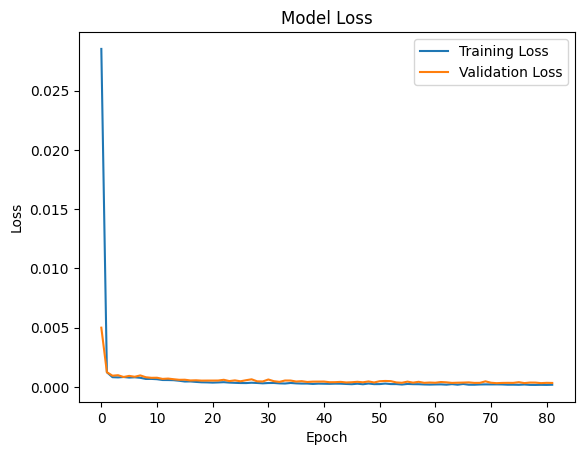

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Langkah selanjunya yaitu melakukan prediksi dengan data test, kemudian membalik (reverse) hasilnya menjadi bentuk data asli. Selanjutnya, lakukan perhitungan metrik error, yaitu RMSE, R², dan MAPE

In [14]:
# Predict with the model
test_predicts = model.predict(x_test)

# Invert predictions
test_predict = scaler.inverse_transform(test_predicts)
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1, 1))  # Ubah bentuk menjadi 2D

# Calculate Metric Error
score_rmse = np.sqrt(mean_squared_error(y_test_inversed, test_predict))
score_r2 = r2_score(y_test_inversed, test_predict)
score_mape = np.mean(np.abs((y_test_inversed - test_predict) / y_test_inversed)) * 100

print(Fore.GREEN + f'RMSE: {score_rmse:.4f}')
print(Fore.GREEN + f'MAPE: {score_mape:.2f}%')
print(Fore.GREEN + f'R2: {score_r2:.4f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
RMSE: 114.0646
MAPE: 0.89%
R2: 0.9569


Terakhir, buatlah plot dalam bentuk grafik agar kita dapat melihat hasilnya.

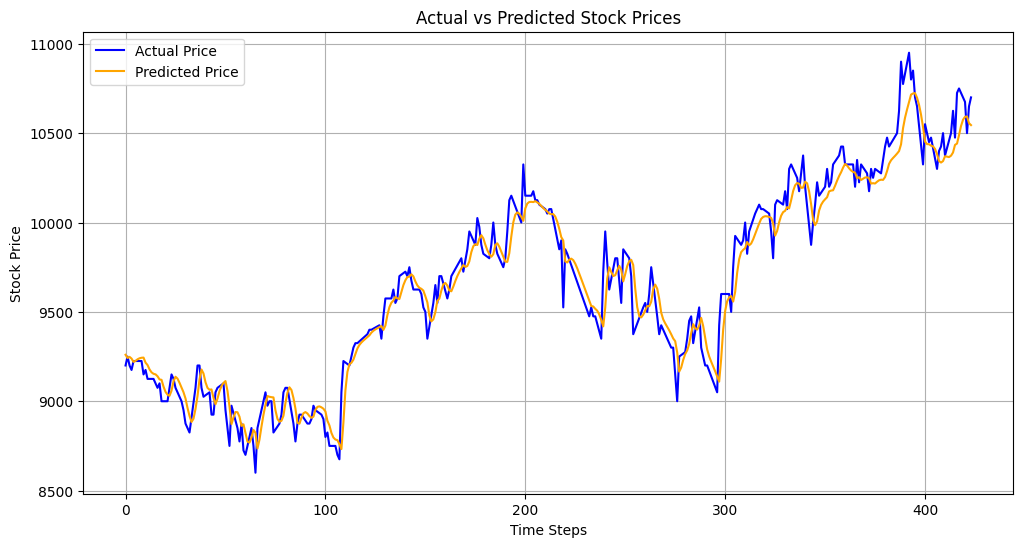

In [15]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual vs predicted
plt.plot(y_test_inversed, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='orange')

# Tambahkan judul dan label
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()

# Tampilkan grafik
plt.show()

# 2. ARIMA

Untuk model kedua, kita akan menggunakan ARIMA, yang merupakan model yang sangat baik untuk memprediksi data time series. Pada model ini, kita mengatur parameter sebagai berikut:

- p=1: Ini artinya kita mempertimbangkan satu nilai sebelumnya untuk membantu memprediksi nilai saat ini.

- d=2: Parameter ini menunjukkan bahwa kita perlu melakukan differencing dua kali untuk membuat data kita stasioner. Pemilihan d=2 dikarenakan data saham ini memiliki tren yang kuat.

- q=1: Parameter ini menunjukkan bahwa kita memperhitungkan satu nilai residual (kesalahan) sebelumnya dalam model.

Dengan pengaturan parameter ini, diharapkan model ARIMA dapat memberikan hasil yang akurat dalam memprediksi data time series yang sedang dianalisis

In [52]:
# Membersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Membagi data menjadi training dan test
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [53]:
# Train model arima
model = ARIMA(train, order=(1, 2, 1))
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1700
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -9765.476
Date:                Tue, 05 Nov 2024   AIC                          19536.951
Time:                        12:50:10   BIC                          19553.263
Sample:                    01-01-2019   HQIC                         19542.990
                         - 08-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0184      0.016     -1.136      0.256      -0.050       0.013
ma.L1         -0.9999      0.083    -12.117      0.000      -1.162      -0.838
sigma2      5764.8713    490.159     11.761      0.0

In [54]:
# Buat predictions
predictions = fitted_model.forecast(steps=len(test))
test.index = predictions.index  # Align test index with predictions for accurate plotting

# Hitung metrik error
score_rmse = np.sqrt(mean_squared_error(test, predictions))
score_r2 = r2_score(test, predictions)
score_mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

print(Fore.GREEN + f'RMSE: {score_rmse:.4f}')
print(Fore.GREEN + f'MAPE: {score_mape:.2f}%')
print(Fore.GREEN + f'R2: {score_r2:.4f}')

RMSE: 353.8909
MAPE: 3.05%
R2: 0.5882


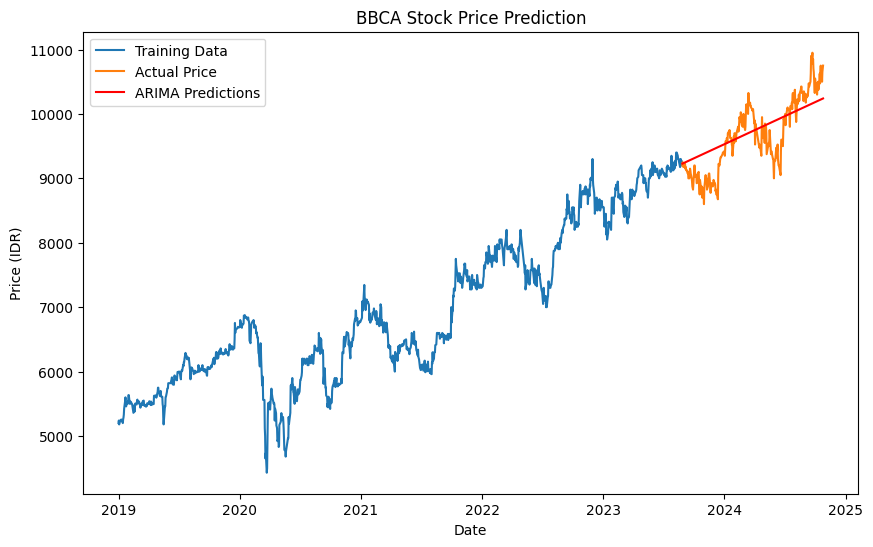

In [55]:
plt.figure(figsize=(10,6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Price')
plt.plot(predictions, color='red', label='ARIMA Predictions')
plt.title('BBCA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()

# Conclusion

Setelah membandingkan kedua model, dapat disimpulkan bahwa model LSTM menghasilkan performa yang superior dengan metrik evaluasi sebagai berikut:

- RMSE: 114.0646
- MAPE: 0.89%
- R²: 0.9569

Hal ini menunjukkan bahwa model LSTM lebih efektif dalam mengidentifikasi pola dalam data dibandingkan model ARIMA.